### biblioteke

In [1]:
import numpy as np
import fastgoertzel as G
from scipy.io import wavfile
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import exists
# import librosa
import scipy.fft as fft
import scipy
from scipy.signal import remez,freqz,firwin
import decimal
from scipy.signal import find_peaks
import binascii
from scipy import signal
%matplotlib widget


import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import zfec
import random
%matplotlib widget

# ulaz je u realnom vremenu sa tastature a izlaz string binarnog koda
def GetMessage(mytextstring = ""):
    if not mytextstring:
        mytextstring = input("Unesite poruku: ")
    
    k = len(mytextstring)
    m = int(k * 1.3)
    msg_ = bytes(mytextstring, 'utf-8')

    a = zfec.easyfec.Encoder(k,m)
    encoded = a.encode(msg_)

    bin_string = ''.join(list(format(int(bin(int.from_bytes(byte_data, byteorder='big'))[2:]), "08") for byte_data in encoded))

    return bin_string

def GenerateRandom(length = 1000):
    bin_string = ""
    
    for _ in range(length):
        bin_string += '1' if bool(random.getrandbits(1)) else '0'
    
    return bin_string

class BitAppender:
    def __init__(self):
        self.buffer = bytearray()
        self.current_byte = 0
        self.bit_count = 0

    def append_bit(self, bit):
        if bit not in (0, 1):
            raise ValueError("Bit must be 0 or 1")

        # Add the bit to the current byte
        self.current_byte = (self.current_byte << 1) | bit
        self.bit_count += 1

        # If we have accumulated 8 bits, store the byte and reset
        if self.bit_count == 8:
            self.buffer.append(self.current_byte)
            self.current_byte = 0
            self.bit_count = 0

    def get_bytes(self):
        # If there are leftover bits, pad with zeros and add the final byte
        if self.bit_count > 0:
            self.current_byte <<= (8 - self.bit_count)
            self.buffer.append(self.current_byte)
        return bytes(self.buffer)



/home/zarko/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [58]:
bin_code = GetMessage("a")
print(bin_code)
print(len(bin_code))

01100001
8


### modulacija

interactive(children=(Text(value='44100', description='fs'), Text(value='10000', description='f0'), Text(value…

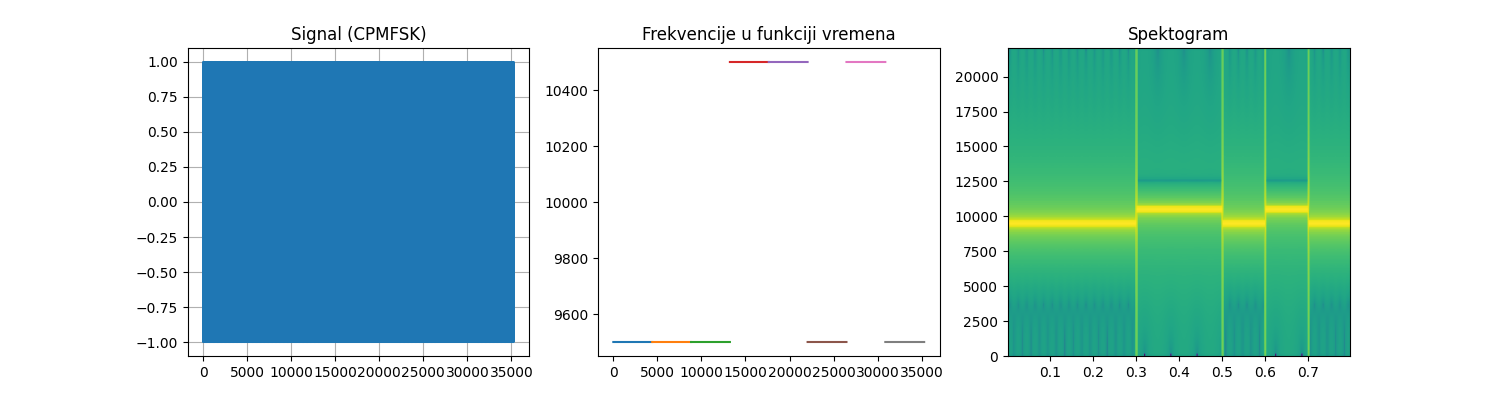

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

mfsk = None
cpmfsk = None
sample_rate = None
bin_code_help = None

@widgets.interact(fs="44100", f0="10000", df = "1000", m="1", dt = "0.1", barker = True, parity = True)
def update(fs = 44100, f0=10000, df=1000, m = 1, dt = "0.1", barker = True, parity = True):

    
    # čišćenje plota
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax[0].grid(True)

    # učitavanje globalnih promenjivih
    global bin_code, mfsk, cpmfsk, sample_rate, bin_code_help
    num_bits = len(bin_code)

    # manipulacija sa ulaznim parametrima
    if fs == "": fs = 44100
    if f0 == "": f0 = 10000
    if df == "": df = 1000
    if m == "": m = 1
    if dt == "": dt = .1

    try:
        m = int(m)
        f0 = float(f0)
        df = float(df)/2
        fs = int(fs)
        dt = float(dt)
    except:
        m = 1
        f0 = 10000
        df = 1000
        fs = 44100
        dt = .1


    # Barker
    if barker:
        barker_code = "0001101"
        new_bin_code = barker_code + bin_code
    else:
        new_bin_code = bin_code

    # Parnost - popravljanje binarnog koda poruke ako se šalje po bajt
    if m >= 8 and parity:
        final_bin_code = new_bin_code[:7] if barker else ""
        b = 7 if barker else 0
        for i in range((num_bits - b) // 8):
            pack = new_bin_code[8 * i + b: 8 * i + 8 + b]
            parity = "1" if sum([int(ch) for ch in pack]) % 2 == 1 else "0"
            final_bin_code += pack + parity
    else: final_bin_code = new_bin_code

    # pravljenje paketa koji se šalju
    bin_code_help = [final_bin_code[m * i : m * i + m] for i in range(len(final_bin_code)//m)]
    if num_bits % m != 0: bin_code_help.append(new_bin_code[-(num_bits % m):] + "0" * (m - (num_bits % m)))
    print(bin_code_help)

    # pravljenje frekvencija za pakete
    f = np.linspace(f0 - df, f0 + df, 2 ** m)

    # priprema za pravljenje mfsk niza
    samples_per_symbol = int(int(fs) * dt)
    time = np.linspace(0, int(num_bits * samples_per_symbol // m), int(num_bits * samples_per_symbol // m))
    mfsk = np.zeros(time.shape)
    
    # pravljenje mfsk niza sa frekvencijama
    for j, bits in enumerate(bin_code_help):
        n = int(bits, 2)
        mfsk[j * samples_per_symbol: (j + 1) * samples_per_symbol] = f[n]
        ax[1].plot(time[j*samples_per_symbol: (j + 1) * samples_per_symbol], mfsk[j * samples_per_symbol: (j + 1) * samples_per_symbol])
    
    # pravljenje cpmfsk signala
    delta_phi = mfsk * np.pi / (fs / 2.0)
    phi = np.cumsum(delta_phi)
    cpmfsk = np.sin(phi)

    # plotovanje signala i spektograma
    fig.set_label(" ")
    ax[0].set_title("Signal (CPMFSK)")
    ax[1].set_title("Frekvencije u funkciji vremena")
    ax[2].set_title("Spektogram")
    ax[0].plot(cpmfsk)
    ax[2].specgram(cpmfsk, Fs=fs, scale='dB')

    # postavljanje novih vrednosti globalnih promenljiva
    sample_rate = fs

### dodavanje suma

interactive(children=(Text(value='10', description='AS'), Text(value='20', description='SNR'), Output()), _dom…

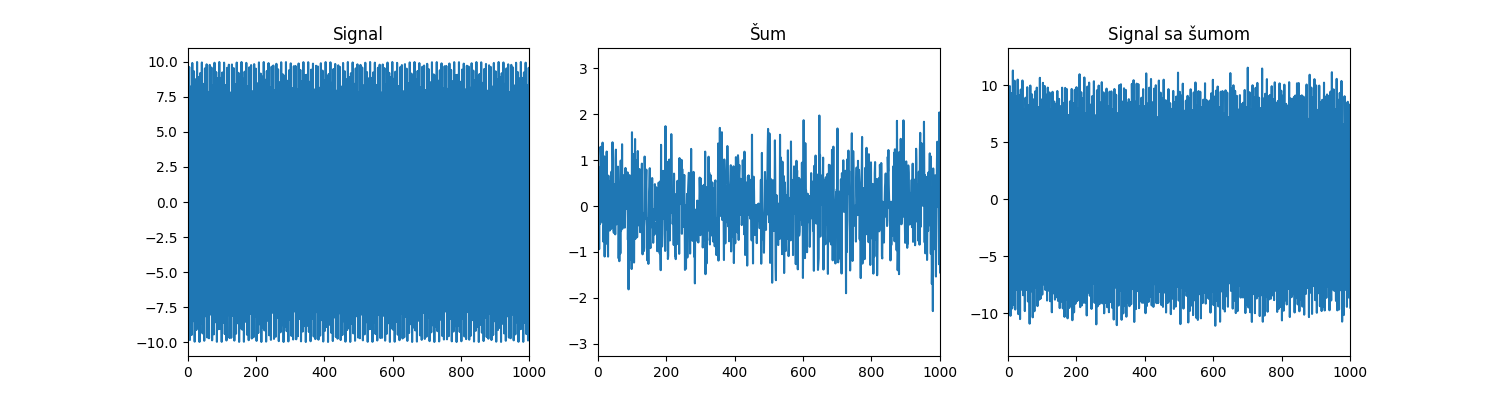

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

after_efect = None
noise = None
signal_with_noise = None

@widgets.interact(AS = "10", SNR = "20")
def update(AS = "10", SNR = "20"):

    # čišćenje plota
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()

    # učitavanje globalnih promenjivih
    global cpmfsk, after_efect, noise, signal_with_noise

    # manipulacija sa ulaznim parametrima
    if AS == "": AS = 10.
    if SNR == "": SNR = 20.
    
    try:
        AS = float(AS)
        SNR = float(SNR)
    except:
        AS = 10
        SNR = 20

    # pojačavanje signala
    after_efect = AS * cpmfsk

    # pravljenje šuma sa određenim SNRom
    snr_db = SNR
    sig_watts = np.mean(after_efect ** 2)
    sig_db = 10 * np.log10(sig_watts)
    noise_db = sig_db - snr_db
    noise_watts = 10 ** (noise_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_watts), len(after_efect))
    
    # spajanje signala i šuma
    signal_with_noise = after_efect + noise

    # plotovanje signala
    fig.set_label(" ")
    ax[0].set_title("Signal")
    ax[1].set_title("Šum")
    ax[2].set_title("Signal sa šumom")
    ax[0].plot(after_efect)
    ax[1].plot(noise)
    ax[2].plot(signal_with_noise)
    ax[0].set_xlim(0, 1000)
    ax[1].set_xlim(0, 1000)
    ax[2].set_xlim(0, 1000)


### demodulacija

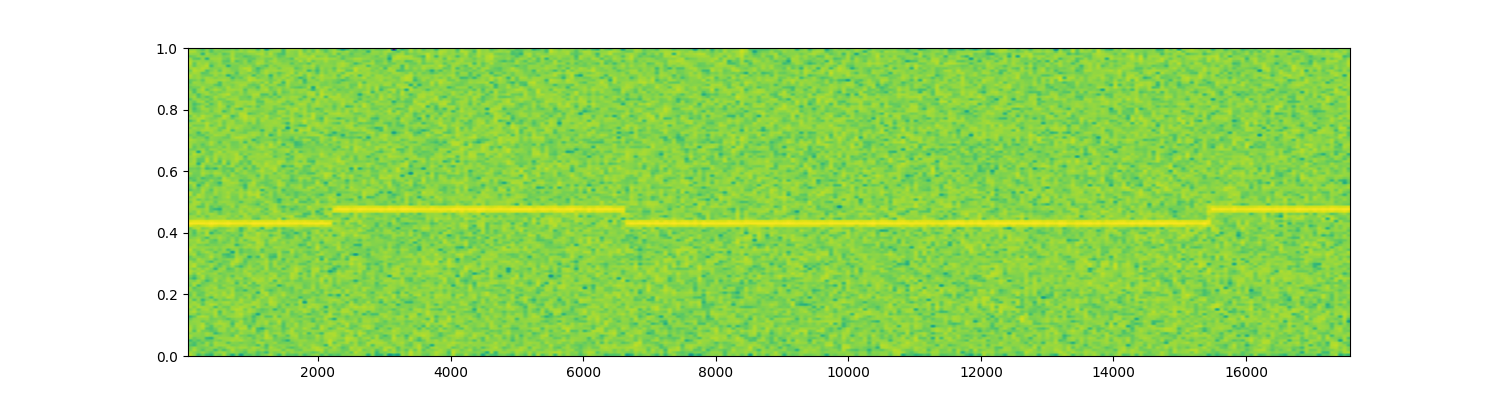

In [61]:
plt.clf()
plt.specgram(signal_with_noise)
plt.show()

In [62]:

sig = signal_with_noise
dt = 0.1
# f0 = 2000
# f1 = 5000
f0=9500
f1=10500
bit_appender = BitAppender()


small_segment = int(sample_rate * dt  * 0.01)
small_segment = 50 # mali delic tako da ne uhvatimo prelaze frekvencija i olaksamo potrebe sinhronizacije
small_segment = 100
# fft sanity check

N = len(sig)

T = 1.0 / sample_rate
x = np.linspace(0.0, N*T, N)
y = sig

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
# plt.clf()
# plt.plot(yf,xf)
# fig, ax = plt.subplots()
# ax.plot(xf[:int(len(sig)/8)], 2.0/N * np.abs(yf[:N//8]))
# plt.show()

peak_tresh = 10000000

binlist = bytearray


# fig, axs = plt.subplots(len(np.arange(0,len(sig)/sample_rate,dt)))
# fig.suptitle('Vertically stacked subplots')
# fig.clear()
# fig.clf()
bl = []
for i in np.arange(0,len(sig)/sample_rate,dt):
    y1 = sig[int(i*sample_rate + small_segment):int((i+dt)*sample_rate) - small_segment]/1
    y1fft = scipy.fft.rfft(y1)

    n = int(dt * sample_rate)- 2 * small_segment
    freqs = fft.rfftfreq(n,1./sample_rate)
    # peaks,props = find_peaks(y1fft,height = peak_tresh)
  
    if f0-300 < freqs[y1fft[15:].argmax()] < f0 + 300: bit_appender.append_bit(0);bl.append(0)
    if f1-300 < freqs[y1fft[15:].argmax()] < f1 +300: bit_appender.append_bit(1);bl.append(1)

result = bit_appender.get_bytes()
print(bl)
print(result)  # Output: b'\xb2\xf3'

[1, 1, 0, 0, 0, 0, 1]
b'\xc2'


In [63]:
print(list(map(int,bin_code_help)) )
print(bl)

[0, 1, 1, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, 1]


### duzina generisanog signala u simbolima

In [64]:
print(len(np.arange(0,len(sig)/sample_rate,dt)))
print(len(bl))
print(len(bin_code_help))

8
7
8


### ber and snr

In [65]:
def calculate_ber_and_attach_snr(list1, list2, snr):
    # Ensure both lists are of the same length
    min_length = min(len(list1), len(list2))
    truncated_list1 = list1[:min_length]
    truncated_list2 = list2[:min_length]
    
    # Calculate the Bit Error Rate (BER)
    errors = sum(bit1 != bit2 for bit1, bit2 in zip(truncated_list1, truncated_list2))
    ber = errors / min_length
    
    # Attach the SNR value
    result = {"BER": ber, "SNR": snr}
    
    return result


list1 = list(map(int,bin_code_help))
list2 =  bl
snr = 1  # Example SNR value

result = calculate_ber_and_attach_snr(list1, list2, snr)
print(result)


{'BER': 0.42857142857142855, 'SNR': 1}
